In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment2/'
FOLDERNAME = None
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

# Introduction to PyTorch

You've written a lot of code in this assignment to provide a whole host of neural network functionality. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. You've also worked hard to make your code efficient and vectorized.

For the last part of this assignment, though, we're going to leave behind your beautiful codebase and instead migrate to one of two popular deep learning frameworks: in this instance, PyTorch.

## Why do we use deep learning frameworks?

* Our code will now run on GPUs! This will allow our models to train much faster. When using a framework like PyTorch you can harness the power of the GPU for your own custom neural network architectures without having to write CUDA code directly (which is beyond the scope of this class).
* In this class, we want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! PyTorch is an excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* Finally, we want you to be exposed to the sort of deep learning code you might run into in academia or industry.

## What is PyTorch?

PyTorch is a system for executing dynamic computational graphs over Tensor objects that behave similarly as numpy ndarray. It comes with a powerful automatic differentiation engine that removes the need for manual back-propagation. 

## How do I learn PyTorch?

One of our former instructors, Justin Johnson, made an excellent [tutorial](https://github.com/jcjohnson/pytorch-examples) for PyTorch. 

You can also find the detailed [API doc](http://pytorch.org/docs/stable/index.html) here. If you have other questions that are not addressed by the API docs, the [PyTorch forum](https://discuss.pytorch.org/) is a much better place to ask than StackOverflow.

# Table of Contents

This assignment has 5 parts. You will learn PyTorch on **three different levels of abstraction**, which will help you understand it better and prepare you for the final project. 

1. Part I, Preparation: we will use CIFAR-10 dataset.
2. Part II, Barebones PyTorch: **Abstraction level 1**, we will work directly with the lowest-level PyTorch Tensors. 
3. Part III, PyTorch Module API: **Abstraction level 2**, we will use `nn.Module` to define arbitrary neural network architecture. 
4. Part IV, PyTorch Sequential API: **Abstraction level 3**, we will use `nn.Sequential` to define a linear feed-forward network very conveniently. 
5. Part V, CIFAR-10 open-ended challenge: please implement your own network to get as high accuracy as possible on CIFAR-10. You can experiment with any layer, optimizer, hyperparameters or other advanced features. 

Here is a table of comparison:

| API           | Flexibility | Convenience |
|---------------|-------------|-------------|
| Barebone      | High        | Low         |
| `nn.Module`     | High        | Medium      |
| `nn.Sequential` | Low         | High        |

# GPU

You can manually switch to a GPU device on Colab by clicking `Runtime -> Change runtime type` and selecting `GPU` under `Hardware Accelerator`. You should do this before running the following cells to import packages, since the kernel gets restarted upon switching runtimes.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 100
print('using device:', device)

using device: cuda


# Part I. Preparation

Now, let's load the CIFAR-10 dataset. This might take a couple minutes the first time you do it, but the files should stay cached after that.

In previous parts of the assignment we had to write our own code to download the CIFAR-10 dataset, preprocess it, and iterate through it in minibatches; PyTorch provides convenient tools to automate this process for us.

In [140]:
NUM_TRAIN = 49000
batch_size = 256

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=batch_size, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=batch_size, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./cs231n/datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Part II. Barebones PyTorch

PyTorch ships with high-level APIs to help us define model architectures conveniently, which we will cover in Part II of this tutorial. In this section, we will start with the barebone PyTorch elements to understand the autograd engine better. After this exercise, you will come to appreciate the high-level model API more.

We will start with a simple fully-connected ReLU network with two hidden layers and no biases for CIFAR classification. 
This implementation computes the forward pass using operations on PyTorch Tensors, and uses PyTorch autograd to compute gradients. It is important that you understand every line, because you will write a harder version after the example.

When we create a PyTorch Tensor with `requires_grad=True`, then operations involving that Tensor will not just compute values; they will also build up a computational graph in the background, allowing us to easily backpropagate through the graph to compute gradients of some Tensors with respect to a downstream loss. Concretely if x is a Tensor with `x.requires_grad == True` then after backpropagation `x.grad` will be another Tensor holding the gradient of x with respect to the scalar loss at the end.

### PyTorch Tensors: Flatten Function
A PyTorch Tensor is conceptionally similar to a numpy array: it is an n-dimensional grid of numbers, and like numpy PyTorch provides many functions to efficiently operate on Tensors. As a simple example, we provide a `flatten` function below which reshapes image data for use in a fully-connected neural network.

Recall that image data is typically stored in a Tensor of shape N x C x H x W, where:

* N is the number of datapoints
* C is the number of channels
* H is the height of the intermediate feature map in pixels
* W is the height of the intermediate feature map in pixels

This is the right way to represent the data when we are doing something like a 2D convolution, that needs spatial understanding of where the intermediate features are relative to each other. When we use fully connected affine layers to process the image, however, we want each datapoint to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data. So, we use a "flatten" operation to collapse the `C x H x W` values per representation into a single long vector. The flatten function below first reads in the N, C, H, and W values from a given batch of data, and then returns a "view" of that data. "View" is analogous to numpy's "reshape" method: it reshapes x's dimensions to be N x ??, where ?? is allowed to be anything (in this case, it will be C x H x W, but we don't need to specify that explicitly). 

In [3]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

test_flatten()

Before flattening:  tensor([[[[ 0,  1],
          [ 2,  3],
          [ 4,  5]]],


        [[[ 6,  7],
          [ 8,  9],
          [10, 11]]]])
After flattening:  tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])


### Barebones PyTorch: Two-Layer Network

Here we define a function `two_layer_fc` which performs the forward pass of a two-layer fully-connected ReLU network on a batch of image data. After defining the forward pass we check that it doesn't crash and that it produces outputs of the right shape by running zeros through the network.

You don't have to write any code here, but it's important that you read and understand the implementation.

In [4]:
import torch.nn.functional as F  # useful stateless functions

def two_layer_fc(x, params):
    """
    A fully-connected neural networks; the architecture is:
    NN is fully connected -> ReLU -> fully connected layer.
    Note that this function only defines the forward pass; 
    PyTorch will take care of the backward pass for us.
    
    The input to the network will be a minibatch of data, of shape
    (N, d1, ..., dM) where d1 * ... * dM = D. The hidden layer will have H units,
    and the output layer will produce scores for C classes.
    
    Inputs:
    - x: A PyTorch Tensor of shape (N, d1, ..., dM) giving a minibatch of
      input data.
    - params: A list [w1, w2] of PyTorch Tensors giving weights for the network;
      w1 has shape (D, H) and w2 has shape (H, C).
    
    Returns:
    - scores: A PyTorch Tensor of shape (N, C) giving classification scores for
      the input data x.
    """
    # first we flatten the image
    x = flatten(x)  # shape: [batch_size, C x H x W]
    
    w1, w2 = params
    
    # Forward pass: compute predicted y using operations on Tensors. Since w1 and
    # w2 have requires_grad=True, operations involving these Tensors will cause
    # PyTorch to build a computational graph, allowing automatic computation of
    # gradients. Since we are no longer implementing the backward pass by hand we
    # don't need to keep references to intermediate values.
    # you can also use `.clamp(min=0)`, equivalent to F.relu()
    x = F.relu(x.mm(w1))
    x = x.mm(w2)
    return x
    

def two_layer_fc_test():
    hidden_layer_size = 42
    x = torch.zeros((64, 50), dtype=dtype)  # minibatch size 64, feature dimension 50
    w1 = torch.zeros((50, hidden_layer_size), dtype=dtype)
    w2 = torch.zeros((hidden_layer_size, 10), dtype=dtype)
    scores = two_layer_fc(x, [w1, w2])
    print(scores.size())  # you should see [64, 10]

two_layer_fc_test()

torch.Size([64, 10])


### Barebones PyTorch: Three-Layer ConvNet

Here you will complete the implementation of the function `three_layer_convnet`, which will perform the forward pass of a three-layer convolutional network. Like above, we can immediately test our implementation by passing zeros through the network. The network should have the following architecture:

1. A convolutional layer (with bias) with `channel_1` filters, each with shape `KW1 x KH1`, and zero-padding of two
2. ReLU nonlinearity
3. A convolutional layer (with bias) with `channel_2` filters, each with shape `KW2 x KH2`, and zero-padding of one
4. ReLU nonlinearity
5. Fully-connected layer with bias, producing scores for C classes.

Note that we have **no softmax activation** here after our fully-connected layer: this is because PyTorch's cross entropy loss performs a softmax activation for you, and by bundling that step in makes computation more efficient.

**HINT**: For convolutions: http://pytorch.org/docs/stable/nn.html#torch.nn.functional.conv2d; pay attention to the shapes of convolutional filters!

In [15]:
def three_layer_convnet(x, params):
    """
    Performs the forward pass of a three-layer convolutional network with the
    architecture defined above.

    Inputs:
    - x: A PyTorch Tensor of shape (N, 3, H, W) giving a minibatch of images
    - params: A list of PyTorch Tensors giving the weights and biases for the
      network; should contain the following:
      - conv_w1: PyTorch Tensor of shape (channel_1, 3, KH1, KW1) giving weights
        for the first convolutional layer
      - conv_b1: PyTorch Tensor of shape (channel_1,) giving biases for the first
        convolutional layer
      - conv_w2: PyTorch Tensor of shape (channel_2, channel_1, KH2, KW2) giving
        weights for the second convolutional layer
      - conv_b2: PyTorch Tensor of shape (channel_2,) giving biases for the second
        convolutional layer
      - fc_w: PyTorch Tensor giving weights for the fully-connected layer. Can you
        figure out what the shape should be?
      - fc_b: PyTorch Tensor giving biases for the fully-connected layer. Can you
        figure out what the shape should be?
    
    Returns:
    - scores: PyTorch Tensor of shape (N, C) giving classification scores for x
    """
    conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b = params
    scores = None
    ################################################################################
    # TODO: Implement the forward pass for the three-layer ConvNet.                #
    ################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    x = F.relu(F.conv2d(x, conv_w1, conv_b1, padding=2))
    x = F.relu(F.conv2d(x, conv_w2, conv_b2, padding=1))
    x = flatten(x)
    scores = x.mm(fc_w) + fc_b

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################
    return scores

After defining the forward pass of the ConvNet above, run the following cell to test your implementation.

When you run this function, scores should have shape (64, 10).

In [16]:
def three_layer_convnet_test():
    x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]

    conv_w1 = torch.zeros((6, 3, 5, 5), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W]
    conv_b1 = torch.zeros((6,))  # out_channel
    conv_w2 = torch.zeros((9, 6, 3, 3), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W]
    conv_b2 = torch.zeros((9,))  # out_channel

    # you must calculate the shape of the tensor after two conv layers, before the fully-connected layer
    fc_w = torch.zeros((9 * 32 * 32, 10))
    fc_b = torch.zeros(10)

    scores = three_layer_convnet(x, [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b])
    print(scores.size())  # you should see [64, 10]
three_layer_convnet_test()

torch.Size([64, 10])


### Barebones PyTorch: Initialization
Let's write a couple utility methods to initialize the weight matrices for our models.

- `random_weight(shape)` initializes a weight tensor with the Kaiming normalization method.
- `zero_weight(shape)` initializes a weight tensor with all zeros. Useful for instantiating bias parameters.

The `random_weight` function uses the Kaiming normal initialization method, described in:

He et al, *Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification*, ICCV 2015, https://arxiv.org/abs/1502.01852

In [17]:
def random_weight(shape):
    """
    Create random Tensors for weights; setting requires_grad=True means that we
    want to compute gradients for these Tensors during the backward pass.
    We use Kaiming normalization: sqrt(2 / fan_in)
    """
    if len(shape) == 2:  # FC weight
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:]) # conv weight [out_channel, in_channel, kH, kW]
    # randn is standard normal distribution generator. 
    w = torch.randn(shape, device=device, dtype=dtype) * np.sqrt(2. / fan_in)
    w.requires_grad = True
    return w

def zero_weight(shape):
    return torch.zeros(shape, device=device, dtype=dtype, requires_grad=True)

# create a weight of shape [3 x 5]
# you should see the type `torch.cuda.FloatTensor` if you use GPU. 
# Otherwise it should be `torch.FloatTensor`
random_weight((3, 5))

tensor([[ 0.9177, -0.3923,  0.4468,  0.2740,  0.5163],
        [-0.7427,  0.9078,  0.9594,  0.0362,  0.2878],
        [-0.0268,  0.8965,  0.4008, -0.1048, -0.3409]], device='cuda:0',
       requires_grad=True)

### Barebones PyTorch: Check Accuracy
When training the model we will use the following function to check the accuracy of our model on the training or validation sets.

When checking accuracy we don't need to compute any gradients; as a result we don't need PyTorch to build a computational graph for us when we compute scores. To prevent a graph from being built we scope our computation under a `torch.no_grad()` context manager.

In [18]:
def check_accuracy_part2(loader, model_fn, params):
    """
    Check the accuracy of a classification model.
    
    Inputs:
    - loader: A DataLoader for the data split we want to check
    - model_fn: A function that performs the forward pass of the model,
      with the signature scores = model_fn(x, params)
    - params: List of PyTorch Tensors giving parameters of the model
    
    Returns: Nothing, but prints the accuracy of the model
    """
    split = 'val' if loader.dataset.train else 'test'
    print('Checking accuracy on the %s set' % split)
    num_correct, num_samples = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.int64)
            scores = model_fn(x, params)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))

### BareBones PyTorch: Training Loop
We can now set up a basic training loop to train our network. We will train the model using stochastic gradient descent without momentum. We will use `torch.functional.cross_entropy` to compute the loss; you can [read about it here](http://pytorch.org/docs/stable/nn.html#cross-entropy).

The training loop takes as input the neural network function, a list of initialized parameters (`[w1, w2]` in our example), and learning rate.

In [25]:
def train_part2(model_fn, params, learning_rate):
    """
    Train a model on CIFAR-10.
    
    Inputs:
    - model_fn: A Python function that performs the forward pass of the model.
      It should have the signature scores = model_fn(x, params) where x is a
      PyTorch Tensor of image data, params is a list of PyTorch Tensors giving
      model weights, and scores is a PyTorch Tensor of shape (N, C) giving
      scores for the elements in x.
    - params: List of PyTorch Tensors giving weights for the model
    - learning_rate: Python scalar giving the learning rate to use for SGD
    
    Returns: Nothing
    """
    for t, (x, y) in enumerate(loader_train):
        # Move the data to the proper device (GPU or CPU)
        x = x.to(device=device, dtype=dtype)
        y = y.to(device=device, dtype=torch.long)

        # Forward pass: compute scores and loss
        scores = model_fn(x, params)
        loss = F.cross_entropy(scores, y)

        # Backward pass: PyTorch figures out which Tensors in the computational
        # graph has requires_grad=True and uses backpropagation to compute the
        # gradient of the loss with respect to these Tensors, and stores the
        # gradients in the .grad attribute of each Tensor.
        loss.backward()

        # Update parameters. We don't want to backpropagate through the
        # parameter updates, so we scope the updates under a torch.no_grad()
        # context manager to prevent a computational graph from being built.
        with torch.no_grad():
            for w in params:
                w -= learning_rate * w.grad

                # Manually zero the gradients after running the backward pass
                w.grad.zero_()

        if t % print_every == 0:
            print('Iteration %d, loss = %.4f' % (t, loss.item()))
            check_accuracy_part2(loader_val, model_fn, params)
            print()

### BareBones PyTorch: Train a Two-Layer Network
Now we are ready to run the training loop. We need to explicitly allocate tensors for the fully connected weights, `w1` and `w2`. 

Each minibatch of CIFAR has 64 examples, so the tensor shape is `[64, 3, 32, 32]`. 

After flattening, `x` shape should be `[64, 3 * 32 * 32]`. This will be the size of the first dimension of `w1`. 
The second dimension of `w1` is the hidden layer size, which will also be the first dimension of `w2`. 

Finally, the output of the network is a 10-dimensional vector that represents the probability distribution over 10 classes. 

You don't need to tune any hyperparameters but you should see accuracies above 40% after training for one epoch.

In [20]:
hidden_layer_size = 4000
learning_rate = 1e-2

w1 = random_weight((3 * 32 * 32, hidden_layer_size))
w2 = random_weight((hidden_layer_size, 10))

train_part2(two_layer_fc, [w1, w2], learning_rate)

Iteration 0, loss = 3.4293
Checking accuracy on the val set
Got 137 / 1000 correct (13.70%)

Iteration 100, loss = 2.5467
Checking accuracy on the val set
Got 338 / 1000 correct (33.80%)

Iteration 200, loss = 1.9229
Checking accuracy on the val set
Got 343 / 1000 correct (34.30%)

Iteration 300, loss = 1.8657
Checking accuracy on the val set
Got 415 / 1000 correct (41.50%)

Iteration 400, loss = 1.7422
Checking accuracy on the val set
Got 375 / 1000 correct (37.50%)

Iteration 500, loss = 1.6255
Checking accuracy on the val set
Got 429 / 1000 correct (42.90%)

Iteration 600, loss = 1.5791
Checking accuracy on the val set
Got 444 / 1000 correct (44.40%)

Iteration 700, loss = 1.5886
Checking accuracy on the val set
Got 467 / 1000 correct (46.70%)



### BareBones PyTorch: Training a ConvNet

In the below you should use the functions defined above to train a three-layer convolutional network on CIFAR. The network should have the following architecture:

1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding of 2
2. ReLU
3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding of 1
4. ReLU
5. Fully-connected layer (with bias) to compute scores for 10 classes

You should initialize your weight matrices using the `random_weight` function defined above, and you should initialize your bias vectors using the `zero_weight` function above.

You don't need to tune any hyperparameters, but if everything works correctly you should achieve an accuracy above 42% after one epoch.

In [27]:
learning_rate = 3e-3

channel_1 = 32
channel_2 = 16

conv_w1 = None
conv_b1 = None
conv_w2 = None
conv_b2 = None
fc_w = None
fc_b = None

################################################################################
# TODO: Initialize the parameters of a three-layer ConvNet.                    #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

conv_w1 = random_weight((32, 3, 5, 5))
conv_b1 = zero_weight(32)
conv_w2 = random_weight((16, 32, 3, 3))
conv_b2 = zero_weight(16)
fc_w = random_weight((16384 , 10))
fc_b = zero_weight(10)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

params = [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b]
train_part2(three_layer_convnet, params, learning_rate)

Iteration 0, loss = 3.2543
Checking accuracy on the val set
Got 118 / 1000 correct (11.80%)

Iteration 100, loss = 2.1600
Checking accuracy on the val set
Got 331 / 1000 correct (33.10%)

Iteration 200, loss = 1.7486
Checking accuracy on the val set
Got 416 / 1000 correct (41.60%)

Iteration 300, loss = 1.4955
Checking accuracy on the val set
Got 418 / 1000 correct (41.80%)

Iteration 400, loss = 1.5405
Checking accuracy on the val set
Got 441 / 1000 correct (44.10%)

Iteration 500, loss = 1.6475
Checking accuracy on the val set
Got 466 / 1000 correct (46.60%)

Iteration 600, loss = 1.6538
Checking accuracy on the val set
Got 478 / 1000 correct (47.80%)

Iteration 700, loss = 1.7330
Checking accuracy on the val set
Got 473 / 1000 correct (47.30%)



# Part III. PyTorch Module API

Barebone PyTorch requires that we track all the parameter tensors by hand. This is fine for small networks with a few tensors, but it would be extremely inconvenient and error-prone to track tens or hundreds of tensors in larger networks.

PyTorch provides the `nn.Module` API for you to define arbitrary network architectures, while tracking every learnable parameters for you. In Part II, we implemented SGD ourselves. PyTorch also provides the `torch.optim` package that implements all the common optimizers, such as RMSProp, Adagrad, and Adam. It even supports approximate second-order methods like L-BFGS! You can refer to the [doc](http://pytorch.org/docs/master/optim.html) for the exact specifications of each optimizer.

To use the Module API, follow the steps below:

1. Subclass `nn.Module`. Give your network class an intuitive name like `TwoLayerFC`. 

2. In the constructor `__init__()`, define all the layers you need as class attributes. Layer objects like `nn.Linear` and `nn.Conv2d` are themselves `nn.Module` subclasses and contain learnable parameters, so that you don't have to instantiate the raw tensors yourself. `nn.Module` will track these internal parameters for you. Refer to the [doc](http://pytorch.org/docs/master/nn.html) to learn more about the dozens of builtin layers. **Warning**: don't forget to call the `super().__init__()` first!

3. In the `forward()` method, define the *connectivity* of your network. You should use the attributes defined in `__init__` as function calls that take tensor as input and output the "transformed" tensor. Do *not* create any new layers with learnable parameters in `forward()`! All of them must be declared upfront in `__init__`. 

After you define your Module subclass, you can instantiate it as an object and call it just like the NN forward function in part II.

### Module API: Two-Layer Network
Here is a concrete example of a 2-layer fully connected network:

In [28]:
class TwoLayerFC(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        # assign layer objects to class attributes
        self.fc1 = nn.Linear(input_size, hidden_size)
        # nn.init package contains convenient initialization methods
        # http://pytorch.org/docs/master/nn.html#torch-nn-init 
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        nn.init.kaiming_normal_(self.fc2.weight)
    
    def forward(self, x):
        # forward always defines connectivity
        x = flatten(x)
        scores = self.fc2(F.relu(self.fc1(x)))
        return scores

def test_TwoLayerFC():
    input_size = 50
    x = torch.zeros((64, input_size), dtype=dtype)  # minibatch size 64, feature dimension 50
    model = TwoLayerFC(input_size, 42, 10)
    scores = model(x)
    print(scores.size())  # you should see [64, 10]
test_TwoLayerFC()

torch.Size([64, 10])


### Module API: Three-Layer ConvNet
It's your turn to implement a 3-layer ConvNet followed by a fully connected layer. The network architecture should be the same as in Part II:

1. Convolutional layer with `channel_1` 5x5 filters with zero-padding of 2
2. ReLU
3. Convolutional layer with `channel_2` 3x3 filters with zero-padding of 1
4. ReLU
5. Fully-connected layer to `num_classes` classes

You should initialize the weight matrices of the model using the Kaiming normal initialization method.

**HINT**: http://pytorch.org/docs/stable/nn.html#conv2d

After you implement the three-layer ConvNet, the `test_ThreeLayerConvNet` function will run your implementation; it should print `(64, 10)` for the shape of the output scores.

In [32]:
class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_classes):
        super().__init__()
        ########################################################################
        # TODO: Set up the layers you need for a three-layer ConvNet with the  #
        # architecture defined above.                                          #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        self.conv1 = nn.Conv2d(in_channel, channel_1, (5, 5), padding=2)
        self.conv2 = nn.Conv2d(channel_1, channel_2, (3, 3), padding=1)
        self.fc = nn.Linear(channel_2 * 32 * 32, num_classes)

        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.kaiming_normal_(self.fc.weight)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                          END OF YOUR CODE                            #       
        ########################################################################

    def forward(self, x):
        scores = None
        ########################################################################
        # TODO: Implement the forward function for a 3-layer ConvNet. you      #
        # should use the layers you defined in __init__ and specify the        #
        # connectivity of those layers in forward()                            #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = flatten(x)
        scores = self.fc(x)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        return scores


def test_ThreeLayerConvNet():
    x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]
    model = ThreeLayerConvNet(in_channel=3, channel_1=12, channel_2=8, num_classes=10)
    scores = model(x)
    print(scores.size())  # you should see [64, 10]
test_ThreeLayerConvNet()

torch.Size([64, 10])


### Module API: Check Accuracy
Given the validation or test set, we can check the classification accuracy of a neural network. 

This version is slightly different from the one in part II. You don't manually pass in the parameters anymore.

In [33]:
def check_accuracy_part34(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

### Module API: Training Loop
We also use a slightly different training loop. Rather than updating the values of the weights ourselves, we use an Optimizer object from the `torch.optim` package, which abstract the notion of an optimization algorithm and provides implementations of most of the algorithms commonly used to optimize neural networks.

In [34]:
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part34(loader_val, model)
                print()

### Module API: Train a Two-Layer Network
Now we are ready to run the training loop. In contrast to part II, we don't explicitly allocate parameter tensors anymore.

Simply pass the input size, hidden layer size, and number of classes (i.e. output size) to the constructor of `TwoLayerFC`. 

You also need to define an optimizer that tracks all the learnable parameters inside `TwoLayerFC`.

You don't need to tune any hyperparameters, but you should see model accuracies above 40% after training for one epoch.

In [35]:
hidden_layer_size = 4000
learning_rate = 1e-2
model = TwoLayerFC(3 * 32 * 32, hidden_layer_size, 10)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_part34(model, optimizer)

Iteration 0, loss = 3.2275
Checking accuracy on validation set
Got 156 / 1000 correct (15.60)

Iteration 100, loss = 1.9123
Checking accuracy on validation set
Got 341 / 1000 correct (34.10)

Iteration 200, loss = 2.5003
Checking accuracy on validation set
Got 367 / 1000 correct (36.70)

Iteration 300, loss = 2.0172
Checking accuracy on validation set
Got 383 / 1000 correct (38.30)

Iteration 400, loss = 1.7594
Checking accuracy on validation set
Got 406 / 1000 correct (40.60)

Iteration 500, loss = 1.7861
Checking accuracy on validation set
Got 455 / 1000 correct (45.50)

Iteration 600, loss = 1.5004
Checking accuracy on validation set
Got 418 / 1000 correct (41.80)

Iteration 700, loss = 1.9353
Checking accuracy on validation set
Got 449 / 1000 correct (44.90)



### Module API: Train a Three-Layer ConvNet
You should now use the Module API to train a three-layer ConvNet on CIFAR. This should look very similar to training the two-layer network! You don't need to tune any hyperparameters, but you should achieve above above 45% after training for one epoch.

You should train the model using stochastic gradient descent without momentum.

In [36]:
learning_rate = 3e-3
channel_1 = 32
channel_2 = 16

model = None
optimizer = None
################################################################################
# TODO: Instantiate your ThreeLayerConvNet model and a corresponding optimizer #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

model = ThreeLayerConvNet(3, channel_1, channel_2, 10)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

train_part34(model, optimizer)

Iteration 0, loss = 3.0661
Checking accuracy on validation set
Got 126 / 1000 correct (12.60)

Iteration 100, loss = 1.8318
Checking accuracy on validation set
Got 323 / 1000 correct (32.30)

Iteration 200, loss = 1.4720
Checking accuracy on validation set
Got 393 / 1000 correct (39.30)

Iteration 300, loss = 1.6230
Checking accuracy on validation set
Got 434 / 1000 correct (43.40)

Iteration 400, loss = 1.7313
Checking accuracy on validation set
Got 446 / 1000 correct (44.60)

Iteration 500, loss = 1.7364
Checking accuracy on validation set
Got 478 / 1000 correct (47.80)

Iteration 600, loss = 1.4899
Checking accuracy on validation set
Got 474 / 1000 correct (47.40)

Iteration 700, loss = 1.5824
Checking accuracy on validation set
Got 485 / 1000 correct (48.50)



# Part IV. PyTorch Sequential API

Part III introduced the PyTorch Module API, which allows you to define arbitrary learnable layers and their connectivity. 

For simple models like a stack of feed forward layers, you still need to go through 3 steps: subclass `nn.Module`, assign layers to class attributes in `__init__`, and call each layer one by one in `forward()`. Is there a more convenient way? 

Fortunately, PyTorch provides a container Module called `nn.Sequential`, which merges the above steps into one. It is not as flexible as `nn.Module`, because you cannot specify more complex topology than a feed-forward stack, but it's good enough for many use cases.

### Sequential API: Two-Layer Network
Let's see how to rewrite our two-layer fully connected network example with `nn.Sequential`, and train it using the training loop defined above.

Again, you don't need to tune any hyperparameters here, but you shoud achieve above 40% accuracy after one epoch of training.

In [37]:
# We need to wrap `flatten` function in a module in order to stack it
# in nn.Sequential
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

hidden_layer_size = 4000
learning_rate = 1e-2

model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 32 * 32, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, 10),
)

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

train_part34(model, optimizer)

Iteration 0, loss = 2.3270
Checking accuracy on validation set
Got 187 / 1000 correct (18.70)

Iteration 100, loss = 1.8239
Checking accuracy on validation set
Got 386 / 1000 correct (38.60)

Iteration 200, loss = 1.7527
Checking accuracy on validation set
Got 401 / 1000 correct (40.10)

Iteration 300, loss = 1.6127
Checking accuracy on validation set
Got 431 / 1000 correct (43.10)

Iteration 400, loss = 1.8308
Checking accuracy on validation set
Got 443 / 1000 correct (44.30)

Iteration 500, loss = 1.8125
Checking accuracy on validation set
Got 426 / 1000 correct (42.60)

Iteration 600, loss = 1.5006
Checking accuracy on validation set
Got 459 / 1000 correct (45.90)

Iteration 700, loss = 1.6134
Checking accuracy on validation set
Got 443 / 1000 correct (44.30)



### Sequential API: Three-Layer ConvNet
Here you should use `nn.Sequential` to define and train a three-layer ConvNet with the same architecture we used in Part III:

1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding of 2
2. ReLU
3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding of 1
4. ReLU
5. Fully-connected layer (with bias) to compute scores for 10 classes

You can use the default PyTorch weight initialization.

You should optimize your model using stochastic gradient descent with Nesterov momentum 0.9.

Again, you don't need to tune any hyperparameters but you should see accuracy above 55% after one epoch of training.

In [38]:
channel_1 = 32
channel_2 = 16
learning_rate = 1e-2

model = None
optimizer = None

################################################################################
# TODO: Rewrite the 3-layer ConvNet with bias from Part III with the           #
# Sequential API.                                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

model = nn.Sequential(
    nn.Conv2d(3, channel_1, (5, 5), padding=2),
    nn.ReLU(),
    nn.Conv2d(channel_1, channel_2, (3, 3), padding=1),
    nn.ReLU(),
    Flatten(),
    nn.Linear(channel_2 * 32 * 32, 10)
)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

train_part34(model, optimizer)

Iteration 0, loss = 2.3137
Checking accuracy on validation set
Got 131 / 1000 correct (13.10)

Iteration 100, loss = 1.5017
Checking accuracy on validation set
Got 424 / 1000 correct (42.40)

Iteration 200, loss = 1.5201
Checking accuracy on validation set
Got 471 / 1000 correct (47.10)

Iteration 300, loss = 1.4272
Checking accuracy on validation set
Got 495 / 1000 correct (49.50)

Iteration 400, loss = 1.4506
Checking accuracy on validation set
Got 531 / 1000 correct (53.10)

Iteration 500, loss = 1.4066
Checking accuracy on validation set
Got 564 / 1000 correct (56.40)

Iteration 600, loss = 1.3180
Checking accuracy on validation set
Got 562 / 1000 correct (56.20)

Iteration 700, loss = 0.9063
Checking accuracy on validation set
Got 565 / 1000 correct (56.50)



# Part V. CIFAR-10 open-ended challenge

In this section, you can experiment with whatever ConvNet architecture you'd like on CIFAR-10. 

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves **at least 70%** accuracy on the CIFAR-10 **validation** set within 10 epochs. You can use the check_accuracy and train functions from above. You can use either `nn.Module` or `nn.Sequential` API. 

Describe what you did at the end of this notebook.

Here are the official API documentation for each component. One note: what we call in the class "spatial batch norm" is called "BatchNorm2D" in PyTorch.

* Layers in torch.nn package: http://pytorch.org/docs/stable/nn.html
* Activations: http://pytorch.org/docs/stable/nn.html#non-linear-activations
* Loss functions: http://pytorch.org/docs/stable/nn.html#loss-functions
* Optimizers: http://pytorch.org/docs/stable/optim.html


### Things you might try:
- **Filter size**: Above we used 5x5; would smaller filters be more efficient?
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use Dropout.

### Tips for training
For each network architecture that you try, you should tune the learning rate and other hyperparameters. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and save your test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these, but don't miss the fun if you have time!

- Alternative optimizers: you can try Adam, Adagrad, RMSprop, etc.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

### Have fun and happy training! 

In [150]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

model_conv_relu_pool = nn.Sequential(
    nn.Conv2d(3, 32, (3, 3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, (3, 3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 128, (3, 3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(128*4*4, 512),
    nn.ReLU(),
    nn.Linear(512, 10)
)

def double_conv_relu(in_channel, out_channel):
    return nn.Sequential(
        nn.Conv2d(in_channel, out_channel, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channel, out_channel, (3, 3), padding=1),
        nn.ReLU()
    )

model_double_conv_relu_pool = nn.Sequential(
    double_conv_relu(3, 32),
    nn.MaxPool2d(2),
    double_conv_relu(32, 64),
    nn.MaxPool2d(2),
    double_conv_relu(64, 128),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(128*4*4, 512),
    nn.ReLU(),
    nn.Linear(512, 10)
)

def double_conv_bn_relu(in_channel, out_channel):
    return nn.Sequential(
        nn.Conv2d(in_channel, out_channel, (3, 3), padding=1),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(),
        nn.Conv2d(out_channel, out_channel, (3, 3), padding=1),
        nn.BatchNorm2d(out_channel),
        nn.ReLU()
    )

model_double_conv_bn_relu_pool = nn.Sequential(
    double_conv_bn_relu(3, 32),
    nn.MaxPool2d(2),
    double_conv_bn_relu(32, 64),
    nn.MaxPool2d(2),
    double_conv_bn_relu(64, 128),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(128*4*4, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, 10)
)

model_multi_conv_bn_relu_pool = nn.Sequential(
    double_conv_bn_relu(3, 32),
    double_conv_bn_relu(32, 32),
    double_conv_bn_relu(32, 32),
    nn.MaxPool2d(2),
    double_conv_bn_relu(32, 64),
    double_conv_bn_relu(64, 64),
    double_conv_bn_relu(64, 64),
    nn.MaxPool2d(2),
    double_conv_bn_relu(64, 128),
    double_conv_bn_relu(128, 128),
    double_conv_bn_relu(128, 128),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(128*4*4, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, 10)
)

In [151]:
import torch.nn.functional as F
from tqdm import tqdm
from copy import deepcopy

def my_check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)

    return float(num_correct) / num_samples

def my_train(model, optimizer, epochs=1, save_loss_every=250):
    loss_history = []
    training_acc_history = []
    best_model = None
    best_val_acc = 0.0
    
    val_acc_history = []
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        #data_bar = tqdm(loader_train, bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
        #data_bar.set_description('Train Epoch: [{}/{}]'.format(e, epochs))
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            
            scores = model(x)
            loss = F.cross_entropy(scores, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if t % save_loss_every == 0:
                loss_history.append(loss.item())

        training_acc = my_check_accuracy(loader_train, model)
        training_acc_history.append(training_acc)
        val_acc = my_check_accuracy(loader_val, model)
        val_acc_history.append(val_acc)

        if val_acc > best_val_acc:
            best_model = deepcopy(model)
            best_val_acc = val_acc
        
        print('Train Epoch: [{}/{}] | Train Accuracy: {:.4f} | Validation Accuracy: {:.4f}'.format(e, epochs, training_acc, val_acc))
                
    return (best_model, loss_history, training_acc_history, val_acc_history)

In [92]:
learning_rate = 1e-2

models = {}
training_log = {}
models['conv_relu_pool'] = model_conv_relu_pool
models['model_double_conv_relu_pool'] = model_double_conv_relu_pool
models['model_double_conv_bn_relu_pool'] = model_double_conv_bn_relu_pool
models['model_multi_conv_bn_relu_pool'] = model_multi_conv_bn_relu_pool

for name, model in models.items():
    print('---\nTraining ', name, '\n---')
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
    training_log[name] = my_train(model, optimizer, epochs=10)
    print('\n')

---
Training  conv_relu_pool 
---


Train Epoch: [0/10]: 100%|██████████| 766/766 [00:12<00:00, 62.58it/s]                                                                                                            


Train Accuracy: 0.6107 | Validation Accuracy: 0.6160


Train Epoch: [1/10]: 100%|██████████| 766/766 [00:11<00:00, 64.40it/s]                                                                                                            


Train Accuracy: 0.7360 | Validation Accuracy: 0.6960


Train Epoch: [2/10]: 100%|██████████| 766/766 [00:12<00:00, 63.30it/s]                                                                                                            


Train Accuracy: 0.8012 | Validation Accuracy: 0.7510


Train Epoch: [3/10]: 100%|██████████| 766/766 [00:12<00:00, 58.95it/s]                                                                                                            


Train Accuracy: 0.8357 | Validation Accuracy: 0.7520


Train Epoch: [4/10]: 100%|██████████| 766/766 [00:12<00:00, 61.84it/s]                                                                                                            


Train Accuracy: 0.8777 | Validation Accuracy: 0.7540


Train Epoch: [5/10]: 100%|██████████| 766/766 [00:12<00:00, 61.05it/s]                                                                                                            


Train Accuracy: 0.9220 | Validation Accuracy: 0.7640


Train Epoch: [6/10]: 100%|██████████| 766/766 [00:11<00:00, 64.11it/s]                                                                                                            


Train Accuracy: 0.9393 | Validation Accuracy: 0.7830


Train Epoch: [7/10]: 100%|██████████| 766/766 [00:12<00:00, 61.00it/s]                                                                                                            


Train Accuracy: 0.9497 | Validation Accuracy: 0.7670


Train Epoch: [8/10]: 100%|██████████| 766/766 [00:12<00:00, 62.58it/s]                                                                                                            


Train Accuracy: 0.9542 | Validation Accuracy: 0.7770


Train Epoch: [9/10]: 100%|██████████| 766/766 [00:12<00:00, 61.26it/s]                                                                                                            


Train Accuracy: 0.9709 | Validation Accuracy: 0.7730


---
Training  model_double_conv_relu_pool 
---


Train Epoch: [0/10]: 100%|██████████| 766/766 [00:12<00:00, 59.08it/s]                                                                                                            


Train Accuracy: 0.4414 | Validation Accuracy: 0.4580


Train Epoch: [1/10]: 100%|██████████| 766/766 [00:12<00:00, 61.78it/s]                                                                                                            


Train Accuracy: 0.6357 | Validation Accuracy: 0.6270


Train Epoch: [2/10]: 100%|██████████| 766/766 [00:12<00:00, 61.30it/s]                                                                                                            


Train Accuracy: 0.7340 | Validation Accuracy: 0.7210


Train Epoch: [3/10]: 100%|██████████| 766/766 [00:12<00:00, 61.10it/s]                                                                                                            


Train Accuracy: 0.7892 | Validation Accuracy: 0.7420


Train Epoch: [4/10]: 100%|██████████| 766/766 [00:12<00:00, 60.04it/s]                                                                                                            


Train Accuracy: 0.8362 | Validation Accuracy: 0.7860


Train Epoch: [5/10]: 100%|██████████| 766/766 [00:12<00:00, 61.56it/s]                                                                                                            


Train Accuracy: 0.8714 | Validation Accuracy: 0.7900


Train Epoch: [6/10]: 100%|██████████| 766/766 [00:12<00:00, 61.83it/s]                                                                                                            


Train Accuracy: 0.9040 | Validation Accuracy: 0.7940


Train Epoch: [7/10]: 100%|██████████| 766/766 [00:12<00:00, 61.13it/s]                                                                                                            


Train Accuracy: 0.9307 | Validation Accuracy: 0.7990


Train Epoch: [8/10]: 100%|██████████| 766/766 [00:12<00:00, 62.26it/s]                                                                                                            


Train Accuracy: 0.9461 | Validation Accuracy: 0.7950


Train Epoch: [9/10]: 100%|██████████| 766/766 [00:12<00:00, 61.54it/s]                                                                                                            


Train Accuracy: 0.9656 | Validation Accuracy: 0.8070


---
Training  model_double_conv_bn_relu_pool 
---


Train Epoch: [0/10]: 100%|██████████| 766/766 [00:13<00:00, 57.36it/s]                                                                                                            


Train Accuracy: 0.7458 | Validation Accuracy: 0.7090


Train Epoch: [1/10]: 100%|██████████| 766/766 [00:13<00:00, 56.88it/s]                                                                                                            


Train Accuracy: 0.7913 | Validation Accuracy: 0.7550


Train Epoch: [2/10]: 100%|██████████| 766/766 [00:13<00:00, 57.30it/s]                                                                                                            


Train Accuracy: 0.8587 | Validation Accuracy: 0.8000


Train Epoch: [3/10]: 100%|██████████| 766/766 [00:13<00:00, 57.31it/s]                                                                                                            


Train Accuracy: 0.9163 | Validation Accuracy: 0.8250


Train Epoch: [4/10]: 100%|██████████| 766/766 [00:13<00:00, 56.91it/s]                                                                                                            


Train Accuracy: 0.9406 | Validation Accuracy: 0.8240


Train Epoch: [5/10]: 100%|██████████| 766/766 [00:13<00:00, 57.38it/s]                                                                                                            


Train Accuracy: 0.9654 | Validation Accuracy: 0.8380


Train Epoch: [6/10]: 100%|██████████| 766/766 [00:13<00:00, 57.03it/s]                                                                                                            


Train Accuracy: 0.9777 | Validation Accuracy: 0.8310


Train Epoch: [7/10]: 100%|██████████| 766/766 [00:13<00:00, 57.55it/s]                                                                                                            


Train Accuracy: 0.9862 | Validation Accuracy: 0.8300


Train Epoch: [8/10]: 100%|██████████| 766/766 [00:13<00:00, 57.50it/s]                                                                                                            


Train Accuracy: 0.9923 | Validation Accuracy: 0.8480


Train Epoch: [9/10]: 100%|██████████| 766/766 [00:13<00:00, 56.43it/s]                                                                                                            


Train Accuracy: 0.9949 | Validation Accuracy: 0.8380


---
Training  model_multi_conv_bn_relu_pool 
---


Train Epoch: [0/10]: 100%|██████████| 766/766 [00:17<00:00, 43.40it/s]                                                                                                            


Train Accuracy: 0.5433 | Validation Accuracy: 0.5420


Train Epoch: [1/10]: 100%|██████████| 766/766 [00:17<00:00, 44.06it/s]                                                                                                            


Train Accuracy: 0.6968 | Validation Accuracy: 0.6690


Train Epoch: [2/10]: 100%|██████████| 766/766 [00:17<00:00, 44.28it/s]                                                                                                            


Train Accuracy: 0.7116 | Validation Accuracy: 0.6890


Train Epoch: [3/10]: 100%|██████████| 766/766 [00:17<00:00, 43.96it/s]                                                                                                            


Train Accuracy: 0.8130 | Validation Accuracy: 0.7870


Train Epoch: [4/10]: 100%|██████████| 766/766 [00:17<00:00, 43.04it/s]                                                                                                            


Train Accuracy: 0.8435 | Validation Accuracy: 0.7990


Train Epoch: [5/10]: 100%|██████████| 766/766 [00:17<00:00, 43.49it/s]                                                                                                            


Train Accuracy: 0.8759 | Validation Accuracy: 0.8180


Train Epoch: [6/10]: 100%|██████████| 766/766 [00:17<00:00, 43.69it/s]                                                                                                            


Train Accuracy: 0.8966 | Validation Accuracy: 0.8300


Train Epoch: [7/10]: 100%|██████████| 766/766 [00:18<00:00, 42.34it/s]                                                                                                            


Train Accuracy: 0.9129 | Validation Accuracy: 0.8300


Train Epoch: [8/10]: 100%|██████████| 766/766 [00:17<00:00, 43.99it/s]                                                                                                            


Train Accuracy: 0.9277 | Validation Accuracy: 0.8320


Train Epoch: [9/10]: 100%|██████████| 766/766 [00:17<00:00, 44.29it/s]                                                                                                            


Train Accuracy: 0.9327 | Validation Accuracy: 0.8270




In [123]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(ResidualBlock, self).__init__()
    
        stride = 2 if downsample else 1    
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

        self.skip_connection = (
            nn.Conv2d(in_channels, out_channels, stride=stride, kernel_size=1)
            if in_channels != out_channels
            else nn.Identity()
        )

    def forward(self, x):
        skip = self.skip_connection(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += skip
        return self.relu(x)

In [147]:
model_my_resnet = nn.Sequential(
    ResidualBlock(3, 32),
    ResidualBlock(32, 32),
    ResidualBlock(32, 32),
    ResidualBlock(32, 64, downsample=True),
    ResidualBlock(64, 64),
    ResidualBlock(64, 64),
    ResidualBlock(64, 128, downsample=True),
    ResidualBlock(128, 128),
    ResidualBlock(128, 128),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(128*4*4, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, 10)
)

model_resnet = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=(3,3), padding=1),
    nn.BatchNorm2d(32),
    ResidualBlock(32, 32),
    ResidualBlock(32, 32),
    ResidualBlock(32, 32),
    ResidualBlock(32, 32),
    ResidualBlock(32, 32),
    ResidualBlock(32, 64, downsample=True),
    ResidualBlock(64, 64),
    ResidualBlock(64, 64),
    ResidualBlock(64, 64),
    ResidualBlock(64, 64),
    ResidualBlock(64, 128, downsample=True),
    ResidualBlock(128, 128),
    ResidualBlock(128, 128),
    ResidualBlock(128, 128),
    ResidualBlock(128, 128),
    nn.AvgPool2d(kernel_size=(8,8)),
    nn.Flatten(),
    nn.Linear(128, 10)
)

In [152]:
models = {}
training_log = {}
models['conv_relu_pool'] = model_conv_relu_pool
models['model_double_conv_relu_pool'] = model_double_conv_relu_pool
models['model_double_conv_bn_relu_pool'] = model_double_conv_bn_relu_pool
models['model_multi_conv_bn_relu_pool'] = model_multi_conv_bn_relu_pool
models['model_my_resnet'] = model_my_resnet
models['model_resnet'] = model_resnet

for name, model in models.items():
    print('---\nTraining ', name, '\n---')
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
    training_log[name] = my_train(model, optimizer, epochs=10)
    print('\n')

---
Training  conv_relu_pool 
---
Train Epoch: [0/10] | Train Accuracy: 0.4476 | Validation Accuracy: 0.4420
Train Epoch: [1/10] | Train Accuracy: 0.5675 | Validation Accuracy: 0.5700
Train Epoch: [2/10] | Train Accuracy: 0.6409 | Validation Accuracy: 0.6240
Train Epoch: [3/10] | Train Accuracy: 0.6856 | Validation Accuracy: 0.6580
Train Epoch: [4/10] | Train Accuracy: 0.7251 | Validation Accuracy: 0.6790
Train Epoch: [5/10] | Train Accuracy: 0.7580 | Validation Accuracy: 0.7180
Train Epoch: [6/10] | Train Accuracy: 0.7549 | Validation Accuracy: 0.7080
Train Epoch: [7/10] | Train Accuracy: 0.8298 | Validation Accuracy: 0.7570
Train Epoch: [8/10] | Train Accuracy: 0.8452 | Validation Accuracy: 0.7550
Train Epoch: [9/10] | Train Accuracy: 0.8698 | Validation Accuracy: 0.7590


---
Training  model_double_conv_relu_pool 
---
Train Epoch: [0/10] | Train Accuracy: 0.1573 | Validation Accuracy: 0.1450
Train Epoch: [1/10] | Train Accuracy: 0.3581 | Validation Accuracy: 0.3390
Train Epoch: [2/1

In [159]:
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=(3,3), padding=1),
    nn.BatchNorm2d(32),
    ResidualBlock(32, 32),
    ResidualBlock(32, 32),
    ResidualBlock(32, 32),
    ResidualBlock(32, 32),
    ResidualBlock(32, 32),
    ResidualBlock(32, 64, downsample=True),
    ResidualBlock(64, 64),
    ResidualBlock(64, 64),
    ResidualBlock(64, 64),
    ResidualBlock(64, 64),
    ResidualBlock(64, 128, downsample=True),
    ResidualBlock(128, 128),
    ResidualBlock(128, 128),
    ResidualBlock(128, 128),
    ResidualBlock(128, 128),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(128*4*4, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, 10)
)

name = 'model_my_resnet_deep'

print('---\nTraining ', name, '\n---')
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
training_log[name] = my_train(model, optimizer, epochs=10)
print('\n')

---
Training  model_my_resnet_deep 
---
Train Epoch: [0/10] | Train Accuracy: 0.6097 | Validation Accuracy: 0.5990
Train Epoch: [1/10] | Train Accuracy: 0.6465 | Validation Accuracy: 0.6240
Train Epoch: [2/10] | Train Accuracy: 0.8207 | Validation Accuracy: 0.7460
Train Epoch: [3/10] | Train Accuracy: 0.8612 | Validation Accuracy: 0.7650
Train Epoch: [4/10] | Train Accuracy: 0.8891 | Validation Accuracy: 0.7580
Train Epoch: [5/10] | Train Accuracy: 0.9497 | Validation Accuracy: 0.7780
Train Epoch: [6/10] | Train Accuracy: 0.9284 | Validation Accuracy: 0.7470
Train Epoch: [7/10] | Train Accuracy: 0.9860 | Validation Accuracy: 0.8010
Train Epoch: [8/10] | Train Accuracy: 0.9956 | Validation Accuracy: 0.8090
Train Epoch: [9/10] | Train Accuracy: 0.9995 | Validation Accuracy: 0.8260




In [ ]:
def plot_training_history(title, label, training_log, marker='.'):
    """utility function for plotting training history"""
    plt.title(title)
    plt.xlabel(label)

    for name, (_, loss, train_acc, val_acc) in training_log:
        label=name
        plt.plot(loss[i], bn_marker, label=label)

    plt.plot(bl_plot, bl_marker, label=label)
    plt.legend(loc='lower center', ncol=num_bn+1) 

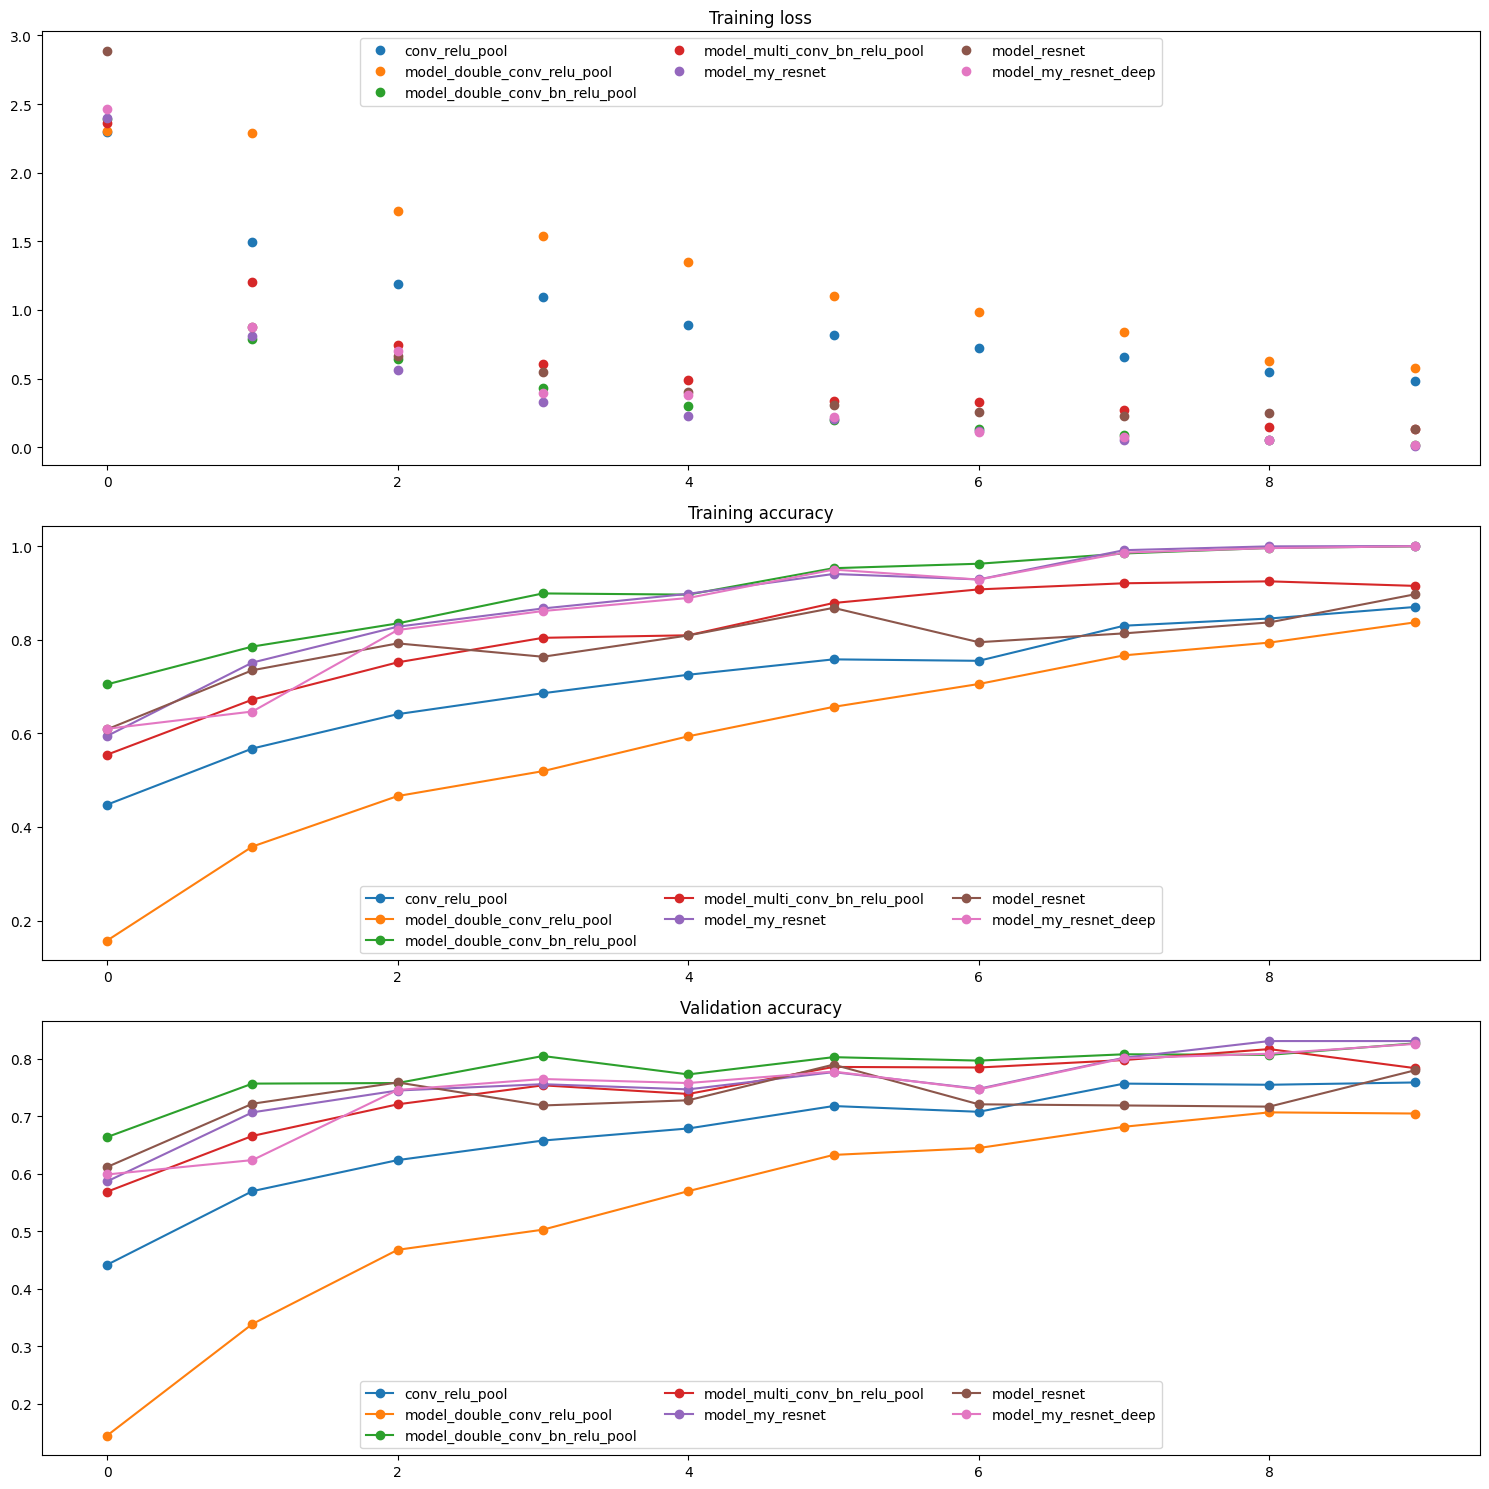

In [160]:
import matplotlib.pyplot as plt
"""
plt.plot(training_acc_history, '-o', label='training_acc')
plt.plot(val_acc_history, '-o', label='val_acc')
"""

fig, axes = plt.subplots(3, 1, figsize = (15,15))

axes[0].set_title("Training loss")
axes[1].set_title("Training accuracy")
axes[2].set_title("Validation accuracy")

for name, log in training_log.items():
    _, loss, train_acc, val_acc = log
    axes[0].plot(loss, 'o', label=name)
    axes[1].plot(train_acc, '-o', label=name)
    axes[2].plot(val_acc, '-o', label=name)
    axes[0].legend(loc='lower center', ncol=4)

axes[0].legend(loc='upper center', ncol=len(training_log)/2)
axes[1].legend(loc='lower center', ncol=len(training_log)/2)
axes[2].legend(loc='lower center', ncol=len(training_log)/2)

#plt.legend(loc='lower center', ncol=2)
plt.tight_layout()
plt.gcf().set_size_inches(15, 15)
plt.show()

In [43]:
################################################################################
# TODO:                                                                        #         
# Experiment with any architectures, optimizers, and hyperparameters.          #
# Achieve AT LEAST 70% accuracy on the *validation set* within 10 epochs.      #
#                                                                              #
# Note that you can use the check_accuracy function to evaluate on either      #
# the test set or the validation set, by passing either loader_test or         #
# loader_val as the second argument to check_accuracy. You should not touch    #
# the test set until you have finished your architecture and  hyperparameter   #
# tuning, and only run the test set once at the end to report a final value.   #
################################################################################
model = None
optimizer = None

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

model = nn.Sequential(
            nn.Conv2d(3, 32, (3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, (3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, (3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128*4*4, 10)
)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# You should get at least 70% accuracy.
# You may modify the number of epochs to any number below 15.
train_part34(model, optimizer, epochs=10)

Iteration 0, loss = 2.3077
Checking accuracy on validation set
Got 100 / 1000 correct (10.00)

Iteration 100, loss = 1.6388
Checking accuracy on validation set
Got 407 / 1000 correct (40.70)

Iteration 200, loss = 1.6069
Checking accuracy on validation set
Got 471 / 1000 correct (47.10)

Iteration 300, loss = 1.4086
Checking accuracy on validation set
Got 532 / 1000 correct (53.20)

Iteration 400, loss = 1.3560
Checking accuracy on validation set
Got 552 / 1000 correct (55.20)

Iteration 500, loss = 1.0661
Checking accuracy on validation set
Got 605 / 1000 correct (60.50)

Iteration 600, loss = 0.8652
Checking accuracy on validation set
Got 598 / 1000 correct (59.80)

Iteration 700, loss = 1.1205
Checking accuracy on validation set
Got 584 / 1000 correct (58.40)

Iteration 0, loss = 0.7218
Checking accuracy on validation set
Got 629 / 1000 correct (62.90)

Iteration 100, loss = 0.7006
Checking accuracy on validation set
Got 665 / 1000 correct (66.50)

Iteration 200, loss = 1.0535
Check

## Describe what you did 

In the cell below you should write an explanation of what you did, any additional features that you implemented, and/or any graphs that you made in the process of training and evaluating your network.

**Answer:**



## Test set -- run this only once

Now that we've gotten a result we're happy with, we test our final model on the test set (which you should store in best_model). Think about how this compares to your validation set accuracy.

In [ ]:
best_model = model
check_accuracy_part34(loader_test, best_model)